# Steps
1. data collection
2. Understanding the data
3. Data cleaning
4. Loading the training set
5. Data preprocessing - images
6. Data preprocessing - Captions
7. Data preparation using Generator Function
8. Word Embeddings
9. Model Architecture
10. Inference
11. Evaluation

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding, LSTM
from keras.layers.merge import add


In [2]:
#read text caption

def readTextFile(path):
    with open(path) as f:
        captions = f.read() #readline to read each line
    return captions
        

In [3]:
captions = readTextFile("flickr_dataset/Flickr8k_text/Flickr8k.token.txt")
captions = captions.split("\n")[:-1]
#len(captions.split("\n"))  --> 40461

In [4]:
len(captions)

40460

In [5]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

In [6]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [7]:
first, second = captions[0].split("\t")
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [8]:
print(captions[2])

1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .


In [9]:
descriptions = {}

for i in range(0,40460):
    first, second = captions[i].split("\t")
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
        
    descriptions[img_name].append(second)

In [10]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
!pip3 install opencv-python

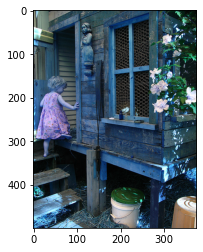

In [11]:
IMG_PATH = "flickr_dataset/Flicker8k_Dataset/"

import cv2
from matplotlib import pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# data cleaning

In [12]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]"," ", sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence
    

In [13]:
clean_text("A cat is sitting over the house number 64")

'cat is sitting over the house number'

In [14]:
#clean all captions
for key, caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [15]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
# write the data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

# Vocabulary
(set of all unique words model can predict)

In [16]:
descriptions = None
with open("descriptions_1.txt","r") as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [17]:
print(type(descriptions))

<class 'dict'>


In [18]:
# Vocab
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))
    

Vocab Size : 8424


In [19]:
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total words %d"%len(total_words))

Total words 373837


In [20]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [21]:
#sort the dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key= lambda x:x[1])

#Filter
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [ ]:
#sorted_freq_cnt
'''
[('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),.............]
 '''

# prepare train/test data

In [22]:
train_file_data = readTextFile("flickr_dataset/Flickr8k_text/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("flickr_dataset/Flickr8k_text/Flickr_8k.testImages.txt")

In [23]:
print(train_file_data[10])

_


In [24]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

print(train[:5])
# print(test[:-10])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87']


In [25]:
train_descriptions= {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append ="startseq "+cap+" endseq"
        train_descriptions[img_id].append(cap_to_append)
        

In [26]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# Transfer Learning

images --> Features
Text ----> Features

## Step 1 Image Feature Extraction


In [27]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [28]:
# resnet --> extract features
model.layers[-2]

In [29]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [30]:
model_new = Model(model.input, model.layers[-2].output)

In [31]:
def preprocess_img(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    # Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


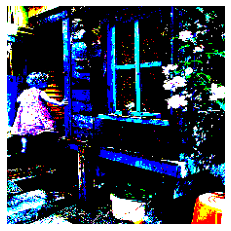

In [32]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()
# print(img)

In [33]:
def encode_img(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [34]:
encode_img(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.06535921, 0.16782534, 0.3251761 , ..., 0.05107138, 0.32821208,
       1.0043364 ], dtype=float32)

In [ ]:
start = time()
encoding_train = {}
#image_id ---> feature_vector extracted from Resnet Image
for ix, img_ig in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_img(img_path)
    
    if ix%100==0 :
        print("Encoding in Progress Time step %d "%ix)
end_t = time()
print("Total time taken :", end_t - start)


In [ ]:
#store every thing to the disk
with open("encoded_train_features.pk1","wb") as f:
    pickle.dump(encoding_train, f)

In [ ]:
start = time()
encoding_test = {}
#image_id ---> feature_vector extracted from Resnet Image
for ix, img_ig in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_img(img_path)
    
    if ix%100==0 :
        print("Test Encoding in Progress Time step %d "%ix)
end_t = time()
print("Total time taken(test) :", end_t - start)


In [ ]:
#store every thing to the disk
with open("encoded_test_features.pk1","wb") as f:
    pickle.dump(encoding_test, f)

### Data Pre-processing for Captions

In [35]:
# Vocab
len(total_words)

1845

In [36]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word
    

In [39]:
print(word_to_idx["dog"])
print(idx_to_word[1])
print(len(idx_to_word))

6
in
1845


In [40]:
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx)+1
print("Vocab Size", vocab_size)

Vocab Size 1848


In [42]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len, len(cap.split()))
        
print(max_len)

35


## Data Loader

In [44]:
    def data_generator(train_descriptions, encoding_train,word_to_idx, max_len, batch_size):
        X1,X2, y = [],[],[]
        
        n=0
        while True:
            for key, desc_list in train_descriptions.items():
                n+=1
                
                photo = encoding_train[key+".jpg"]
                for desc in desc_list:
                    seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                    for i in range(1, len(seq)):
                        xi = seq[0:i]
                        yi = seq[i]
                        
                        # 0 denote padding word
                        xi = pad_sequence([xi],maxlen = maxlen, value = 0, padding = 'post')
                        yi = to_categorical([yi], num_classes = vocab_size)[0]
                        
                        X1.append(photo)
                        X2.append(xi)
                        y.append(yi)
                        
                    if n == batch_size:
                        yield [[np.array(X1), np.array(X2)],np.array(y)]
                        
                        X1,X2,y = [],[],[]
                        n=0
                        